In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 18413878115677784605
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 6560351959850025470
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 13668265913106121201
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14648777152
locality {
  bus_id: 1
  links {
  }
}
incarnation: 1361417209803225995
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
]


In [3]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
from wordcloud import WordCloud

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Conv1D, MaxPool1D
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata
from keras.preprocessing import text, sequence
from nltk.tokenize.toktok import ToktokTokenizer
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from string import punctuation
from nltk import pos_tag
from nltk.corpus import wordnet
import keras
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout
from keras.callbacks import ReduceLROnPlateau
import tensorflow as tf

Using TensorFlow backend.


In [4]:
# !wget https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit?usp=sharing

In [5]:
# !unzip *distance*.bin -d '/content/gdrive/My Drive/twitter misinfo/'

In [6]:
real = pd.read_csv('/content/gdrive/My Drive/twitter misinfo/2020_04_10000_real_tweets.csv', header = None)
fake = pd.read_csv('/content/gdrive/My Drive/twitter misinfo/2020_04_10000_fake_tweets_unconditional.csv', header = None)


In [7]:
real.columns = ['tweet']

In [8]:
real['index'] = real.index

In [9]:
fake.columns = ['tweet']
fake['index'] = fake.index

In [10]:
cols = real.columns.tolist()
cols = cols[-1:] + cols[:-1]

In [11]:
real = real[cols]

In [12]:
cols = fake.columns.tolist()
cols = cols[-1:] + cols[:-1]
fake = fake[cols]

In [13]:
real['category'] = 1
fake['category'] = 0
real.head()

,index,tweet,category
0,0,#Taiwan isn't a member of the #WHO. Taiwan tr...,1
1,1,From the DJs to the CJs.. Look whose in the PJ...,1
2,2,The @ClinicalBioinfo led by @xdopazo releases ...,1
3,3,IMF expects #Greece to be the worst hit econom...,1
4,4,More on #COVID19 - China witnessed a slight in...,1


In [14]:
fake.head()

,index,tweet,category
0,0,@chrislhayes I think it's important to note th...,0
1,1,"The problem is, it's the Chinese that are bein...",0
2,2,Do you know of any people who are looking for ...,0
3,3,Just as the COVID-19 pandemic has shown that t...,0
4,4,Covid-19's impact on the economy: The RBC Stat...,0


In [15]:
fake['tweet'][0]

"@chrislhayes I think it's important to note that there are two big areas that need to be addressed. First, the coronavirus and the existing system. Second, the existing system and health systems.  The first is very, very important, and that's a big concern. "

In [16]:
combined = pd.concat([fake, real])
features = combined['tweet']
labels = combined['category']
combined = combined.sample(frac = 1).reset_index(drop = True)
combined['index'] = combined.index
combined.tail()
combined.isna().sum()
combined.dropna(axis = 0)

,index,tweet,category
0,0,As the #coronavirus pandemic continues to unfo...,0
1,1,The US has lost more than a billion Americans ...,0
2,2,@Mawunya_ @SkyNews @MusinguziElly1 China is a ...,1
3,3,This is why I can't stay at home,0
4,4,Half million cases now in USA.,1
...,...,...,...
19992,19992,@IanDunt Not extending transition is mad. The ...,1
19993,19993,Great to see @NHSNHS is stepping up their #COV...,0
19994,19994,Japan to fund firms to shift prod out of China...,1
19995,19995,Fascist Modi ordered this #earthquake to diver...,1


In [17]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

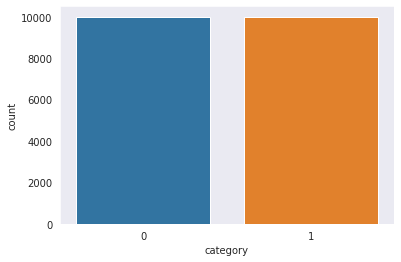

In [18]:
sns.set_style('dark')
sns.countplot(combined.category)

In [19]:
# combined['tweet'] = combined['tweet'].astype(str).str.replace('[^a-zA-Z]',' ').str.lower()

In [20]:
import string

stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

In [21]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

# Removing URL's
def remove_between_square_brackets(text):
    return re.sub(r'http\S+', '', text)

#Removing the stopwords from text
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            final_text.append(i.strip())
    return " ".join(final_text)

#Removing the noisy text
def denoise_text(text):
    text = strip_html(str(text))
    text = remove_between_square_brackets(str(text))
    text = remove_stopwords(str(text))
    return text

#Apply function on review column
combined['tweet']=combined['tweet'].apply(denoise_text)

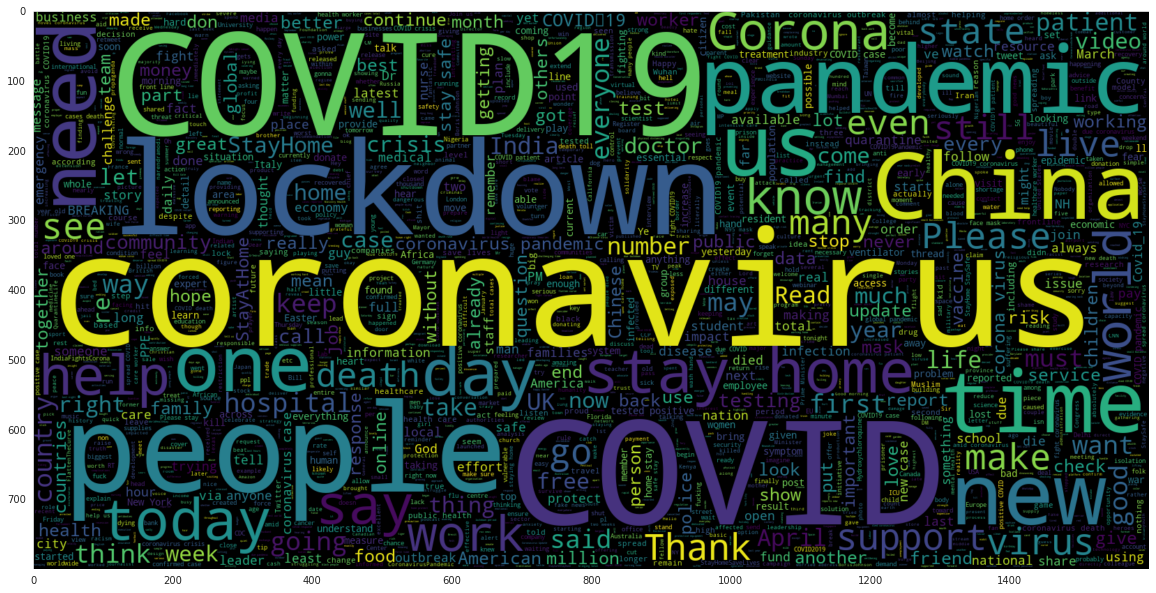

In [22]:
plt.figure(figsize = (20,20)) # Text that is not Fake
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(" ".join(combined[combined.category == 1].tweet))
plt.imshow(wc , interpolation = 'bilinear')

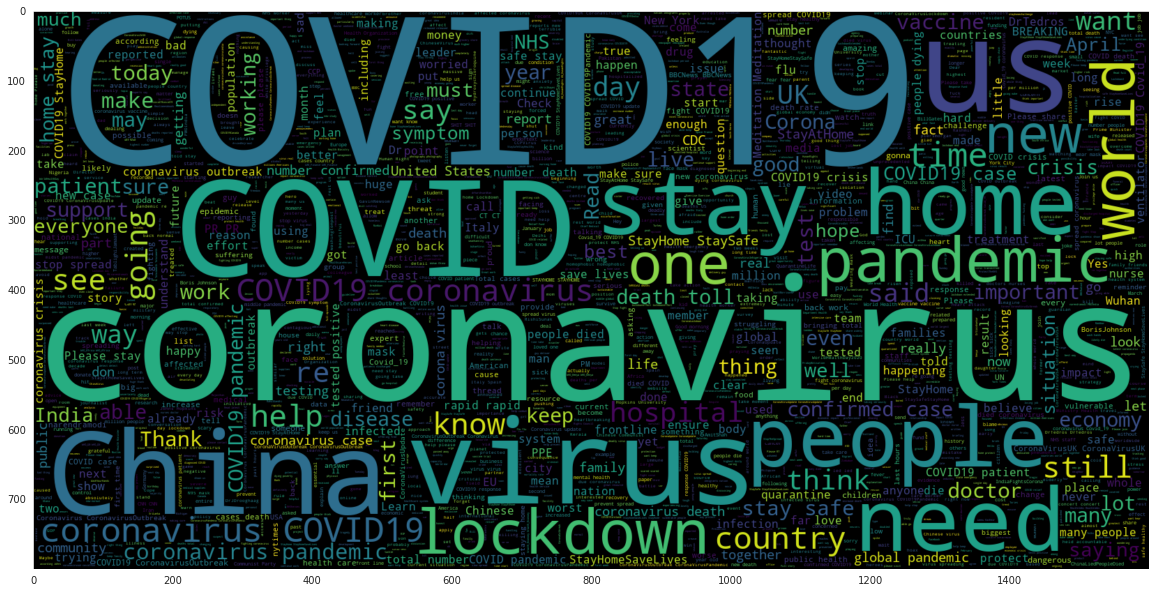

In [23]:
plt.figure(figsize = (20,20)) # Text that is not Fake
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(" ".join(combined[combined.category == 0].tweet))
plt.imshow(wc , interpolation = 'bilinear')

In [24]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [25]:
y = combined['category'].values
#Converting X to format acceptable by gensim, removing annd punctuation stopwords in the process
X = []
stop_words = set(nltk.corpus.stopwords.words("english"))
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
for par in combined['tweet'].values:
    tmp = []
    sentences = nltk.sent_tokenize(par)
    for sent in sentences:
        sent = sent.lower()
        tokens = tokenizer.tokenize(sent)
        filtered_words = [w.strip() for w in tokens if w not in stop_words and len(w) > 1]
        tmp.extend(filtered_words)
    X.append(tmp)

del combined

In [26]:
import gensim

EMBEDDING_DIM = 100

w2v_model = gensim.models.Word2Vec(sentences = X, size = EMBEDDING_DIM, window = 5, min_count = 1)


In [27]:
len(w2v_model.wv.vocab)

38242

In [28]:
w2v_model['pandemic']

array([-1.3405397 , -0.5014397 , -0.77703613,  1.3030874 ,  0.01066362,
       -1.028873  , -1.357154  ,  1.2249033 ,  0.66968864,  0.10522845,
       -1.8206127 , -0.7099347 ,  0.62399495,  0.5768918 ,  0.10447412,
       -0.5880979 , -0.8667196 ,  0.9242113 ,  0.07470336, -0.08520836,
       -0.3164323 , -1.0272295 , -0.39178497, -1.7371008 , -0.9672948 ,
       -0.6115323 ,  1.3291116 , -0.93236226, -1.8748382 , -1.3919827 ,
       -0.2494766 , -0.02150871, -0.35665056,  1.3809645 , -0.28544334,
       -0.341561  , -0.01410741, -0.41243663,  1.4567513 ,  0.14825633,
        0.5688989 , -0.96199834, -0.8411836 , -0.6472748 ,  0.03915839,
       -0.17567793, -2.077495  , -1.2439426 , -0.6141369 , -0.7368817 ,
       -0.10301901, -0.8499774 , -0.9427107 ,  0.9690054 ,  0.98656535,
       -1.7579885 , -0.41628093,  1.9148744 ,  0.42786866, -1.2008936 ,
       -0.51872957,  1.087234  , -0.9660166 ,  1.4918207 ,  0.6210339 ,
       -0.9582677 , -1.048446  ,  1.6775049 ,  1.4970223 , -0.91

In [29]:
w2v_model.wv.most_similar('pandemic')

[('midst', 0.9933578968048096),
 ('crisis', 0.9913985729217529),
 ('middle', 0.9849371314048767),
 ('dire', 0.9805952310562134),
 ('impact', 0.9797143340110779),
 ('profound', 0.978579044342041),
 ('concerned', 0.9784339666366577),
 ('affecting', 0.9771608114242554),
 ('frontlines', 0.9761030673980713),
 ('affected', 0.9760333299636841)]

In [30]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)

X = tokenizer.texts_to_sequences(X)

In [31]:
X[0][:10]

[1, 5, 755, 4620, 2, 84, 4621, 49, 4622, 5915]

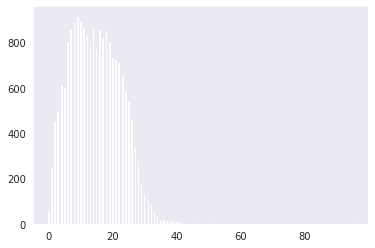

In [32]:
plt.hist([len(x) for x in X], bins=500)
plt.show()

In [33]:
nos = np.array([len(x) for x in X])
len(nos[nos  < 30])

19469

In [34]:
maxlen = 30 

#Making all news of size maxlen defined above
X = pad_sequences(X, maxlen=maxlen)

vocab_size = len(tokenizer.word_index) + 1

In [35]:
def get_weight_matrix(model, vocab):
    # total vocabulary size plus 0 for unknown words
    vocab_size = len(vocab) + 1
    # define weight matrix dimensions with all 0
    weight_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
    # step vocab, store vectors using the Tokenizer's integer mapping
    for word, i in vocab.items():
        weight_matrix[i] = model[word]
    return weight_matrix

word_index = tokenizer.word_index

In [36]:
embedding_vectors = get_weight_matrix(w2v_model, word_index)

In [37]:
#Defining Neural Network
model = Sequential()
#Non-trainable embeddidng layer
model.add(Embedding(vocab_size, output_dim=EMBEDDING_DIM, weights=[embedding_vectors], input_length=maxlen, trainable=False))
#LSTM 
model.add(LSTM(units=128))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

del embedding_vectors

In [38]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 30, 100)           3824300   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 3,941,677
Trainable params: 117,377
Non-trainable params: 3,824,300
_________________________________________________________________


In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y) 

In [40]:
model.fit(X_train, y_train, validation_split=0.3, epochs=15)

Train on 10497 samples, validate on 4500 samples
Epoch 1/15
10497/10497 [==============================] - 19s 2ms/step - loss: 0.5322 - acc: 0.7221 - val_loss: 0.5126 - val_acc: 0.7400
Epoch 2/15
10497/10497 [==============================] - 18s 2ms/step - loss: 0.4967 - acc: 0.7533 - val_loss: 0.4810 - val_acc: 0.7678
Epoch 3/15
10497/10497 [==============================] - 18s 2ms/step - loss: 0.4793 - acc: 0.7654 - val_loss: 0.5054 - val_acc: 0.7467
Epoch 4/15
10497/10497 [==============================] - 18s 2ms/step - loss: 0.4664 - acc: 0.7740 - val_loss: 0.4762 - val_acc: 0.7678
Epoch 5/15
10497/10497 [==============================] - 17s 2ms/step - loss: 0.4611 - acc: 0.7741 - val_loss: 0.4771 - val_acc: 0.7636
Epoch 6/15
10497/10497 [==============================] - 18s 2ms/step - loss: 0.4537 - acc: 0.7795 - val_loss: 0.4618 - val_acc: 0.7784
Epoch 7/15
10497/10497 [==============================] - 19s 2ms/step - loss: 0.4458 - acc: 0.7813 - val_loss: 0.4602 - val_acc:

In [41]:
y_pred = (model.predict(X_test) >= 0.5).astype("int")

In [42]:
accuracy_score(y_test, y_pred)

0.769

In [43]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.71      0.76      2512
           1       0.74      0.83      0.78      2488

    accuracy                           0.77      5000
   macro avg       0.77      0.77      0.77      5000
weighted avg       0.77      0.77      0.77      5000



In [44]:
del model

In [45]:
!wget "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"

--2020-06-23 23:16:11--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.41.46
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.41.46|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘GoogleNews-vectors-negative300.bin.gz.2’

GoogleNews-vectors- 100%[===================>]   1.53G  32.0MB/s    in 50s     

2020-06-23 23:17:02 (31.5 MB/s) - ‘GoogleNews-vectors-negative300.bin.gz.2’ saved [1647046227/1647046227]



In [46]:
import gensim
from gensim.models.keyedvectors import KeyedVectors

word_vectors = KeyedVectors.load_word2vec_format('/content/GoogleNews-vectors-negative300.bin.gz', binary=True)
EMBEDDING_DIM = 300


In [47]:
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
for word, i in word_index.items():
    try:
        embedding_vector = word_vectors[word]
        embedding_matrix[i] = embedding_vector
    except KeyError:
        embedding_matrix[i]=np.random.normal(0,np.sqrt(0.25),EMBEDDING_DIM)

del word_vectors 

In [48]:
from tensorflow.keras.layers import Conv1D, MaxPool1D, LSTM

In [49]:
# from keras import models
# from tensorflow.keras import models

In [50]:
model = Sequential()
model.add(Embedding(vocab_size, output_dim=EMBEDDING_DIM, weights=[embedding_matrix], input_length=maxlen, trainable=False))
model.add(keras.layers.Conv1D(activation='relu', filters=4, kernel_size=4))
model.add(keras.layers.MaxPool1D())
model.add(keras.layers.LSTM(units=128))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

del embedding_matrix

In [51]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 30, 300)           11472900  
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 27, 4)             4804      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 13, 4)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               68096     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 11,545,929
Trainable params: 73,029
Non-trainable params: 11,472,900
_________________________________________________________________


In [52]:
model.fit(X_train, y_train, validation_split=0.3, epochs=15)

Train on 10497 samples, validate on 4500 samples
Epoch 1/15
10497/10497 [==============================] - 13s 1ms/step - loss: 0.5794 - acc: 0.6836 - val_loss: 0.5412 - val_acc: 0.7142
Epoch 2/15
10497/10497 [==============================] - 11s 1ms/step - loss: 0.4987 - acc: 0.7505 - val_loss: 0.5485 - val_acc: 0.7293
Epoch 3/15
10497/10497 [==============================] - 10s 917us/step - loss: 0.4694 - acc: 0.7709 - val_loss: 0.5239 - val_acc: 0.7458
Epoch 4/15
10497/10497 [==============================] - 10s 925us/step - loss: 0.4473 - acc: 0.7844 - val_loss: 0.5382 - val_acc: 0.7398
Epoch 5/15
10497/10497 [==============================] - 9s 898us/step - loss: 0.4281 - acc: 0.7978 - val_loss: 0.5417 - val_acc: 0.7453
Epoch 6/15
10497/10497 [==============================] - 9s 902us/step - loss: 0.4111 - acc: 0.8119 - val_loss: 0.5474 - val_acc: 0.7349
Epoch 7/15
10497/10497 [==============================] - 10s 916us/step - loss: 0.3952 - acc: 0.8195 - val_loss: 0.5749 - 

In [53]:
y_pred = (model.predict(X_test) > 0.5).astype("int")

In [54]:
accuracy_score(y_test, y_pred)

0.7212

In [55]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.71      0.76      0.73      2512
           1       0.74      0.68      0.71      2488

    accuracy                           0.72      5000
   macro avg       0.72      0.72      0.72      5000
weighted avg       0.72      0.72      0.72      5000

